# Image Denoising with RBF Rgression
Image Denoising is a long-standing problem in areas of signal processing and computer vision.
The measurements in physical processes are typically noisy and noise removal is a crucial step to
obtain the underlying ground-truth signal.
In this notebook, you are going to use the radial basis regression model that you implemented in the start code, and denoise an input image corrupted by salt-and-pepper noise. You will try different settings of widths of RBFs and their spacings to see their effects. 
The result of these experiments are visualized using `matplotlib` library.
The goal is to describe the plots, characterize overfitting/undefitting scenarios and explain them.

In [1]:
# initial imports

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from rbf_regression import RBFRegression

### Load Image
First we use `Pillow` library to read the lighthouse image. To reduce later computations, we resize the image by a factor of two yielding an image of size 384x256.

In [2]:
# Read the Image
image_name = './lighthouse.png'
img = Image.open(image_name)
img = img.resize((img.size[0] // 2, img.size[1] // 2))
img = np.array(img) / 255 
img = img.astype(np.float32)

## Salt-and-pepper noise

Image Denoising is a long-standing problem in areas of signal processing and computer vision.
The measurements in physical processes are typically noisy and noise removal is a crucial step to
obtain the underlying ground-truth signal. In this question, we aim to deal with the salt-and-pepper
noise. 
With `salt_prob` any pixel changes to white pixel, namely `salt_rgb=(255,255,255)`.
With `pepper_prob` any pixel changes to black pixel, namely `salt_rgb=(0,0,0)`.
This noise appears as sparsely occurring white and black pixels as shown in the visualization. 
We simulate this noise for the load image:

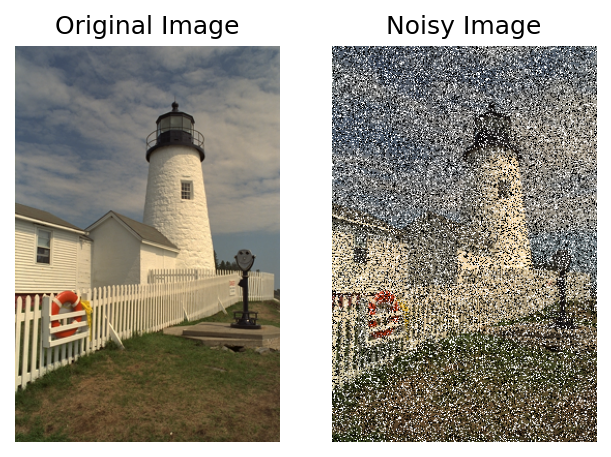

In [3]:
pepper_rgb = np.array([0, 0, 0])
pepper_rgb = pepper_rgb.astype(np.float32) / 255
salt_rgb = np.array([255, 255, 255])
salt_rgb = salt_rgb.astype(np.float32) / 255

def add_salt_and_pepper_noise(image, salt_prob, pepper_prob):
    noisy_image = np.copy(image)
    
    # Add salt noise
    salt_pixels = np.random.rand(*image.shape[:-1]) < salt_prob
    noisy_image[salt_pixels] = 1

    # Add pepper noise
    pepper_pixels = np.random.rand(*image.shape[:-1]) < pepper_prob
    noisy_image[pepper_pixels] = 0

    return noisy_image

noisy_img = add_salt_and_pepper_noise(img, 0.2, 0.2)
fig, axs = plt.subplots(1, 2, figsize=(5, 4), dpi=150)
axs[0].imshow(img)
axs[0].set_title('Original Image')
axs[1].imshow(noisy_img)
axs[1].set_title('Noisy Image')
axs[0].set_axis_off()
axs[1].set_axis_off()
plt.show()

## Denoising function

Next, the `denoising` function is defined. This function takes in an image and then split it into individual patches of size `patch_size`. The function iterates through image patches and a separate RBF model is fitted in a regularized fashion (with `l2_coeff` as $lambda$) to each patch. The centers of RBF are placed with even spacing of `spacing` and same widths of `width`.

In [4]:
def denoising(im, spacing, width, patch_size, l2_coeff, tolerance):
    im_rec = im.copy() # reconstruction or denoised
    H, W = im.shape[:2]

    # i corresponds to left-to-right
    # j corresponds to up-to-down
    for i in range(0, W-patch_size+1, patch_size):
        for j in range(0, H-patch_size+1, patch_size):
            # Grid of pixel coordinates in the patch
            XX, YY = np.meshgrid(np.arange(i, i+patch_size), np.arange(j, j+patch_size))
            P = np.stack([YY, XX], axis=0).reshape(-1, 2)
            
            # Uses squared distance to find indcies to be filled
            patch = im[j:j+patch_size, i:i+patch_size]
            ref1 = ((patch - salt_rgb) ** 2).sum(axis=2)
            ref2 = ((patch - pepper_rgb) ** 2).sum(axis=2)
            cond = np.logical_or(ref1 <= tolerance, ref2 <= tolerance)
            index_fill = np.argwhere(cond) # if close to fill_rgb, then fill
            index_data = np.argwhere(~cond) # if not close to fill_rgb, then data
            idx_data = np.sort(index_data[:,1]*ref1.shape[0]+index_data[:,0])
            idx_fill = np.sort(index_fill[:,1]*ref1.shape[0]+index_fill[:,0])

            # Place RBFs over image patch with even spacing and same widths
            XX, YY = np.meshgrid(list(range(i, i+patch_size, spacing)),
                                list(range(j, j+patch_size, spacing)))

            centers = np.array((XX.flatten(), YY.flatten()), dtype=np.float32).T
            num_centers = centers.shape[0]
            widths = np.ones(shape=(num_centers, 1), dtype=np.float32) * width

            # Construct one model for each color channel
            red_model = RBFRegression(centers=centers, widths=widths)
            green_model = RBFRegression(centers=centers, widths=widths)
            blue_model = RBFRegression(centers=centers, widths=widths)
            
            # If there are pixels that need to be filled, then we try to train the models and fill.
            # Otherwise, we use the original patch
            if (idx_fill.size>0):
                # print('Reconstructing patch at selected color')
                if(idx_data.size <= num_centers):
                    # print('Not enough pixels to estimate RBF model! copying patch\n')
                    patch_rec = patch.copy()
                else:
                    # Valid locations for sampling pixels
                    P_data = P[idx_data]

                    # Reconstruct each colour layer using a separate RBF model
                    # Red channel
                    patch_R = patch[:,:,0]
                    z_R = patch_R.reshape(patch_R.size, 1, order='F')
                    z_R = z_R[idx_data]
                    red_model.fit_with_l2_regularization(P_data, z_R, l2_coeff)
                    
                    # Green channel
                    patch_G = patch[:,:,1]
                    z_G = patch_G.reshape(patch_G.size, 1, order='F')
                    z_G = z_G[idx_data]
                    green_model.fit_with_l2_regularization(P_data, z_G, l2_coeff)
                    
                    # Blue channel
                    patch_B = patch[:,:,2]
                    z_B = patch_B.reshape(patch_B.size, 1, order='F')
                    z_B = z_B[idx_data]
                    blue_model.fit_with_l2_regularization(P_data, z_B, l2_coeff)
                    
                    # Reconstruct pixel values at fill-in locations
                    P_fill = P[idx_fill]
                    fill_R = red_model.predict(P_fill)
                    fill_G = green_model.predict(P_fill)
                    fill_B = blue_model.predict(P_fill)
                    
                    # Assemble reconstructed patch
                    patch_rec = patch.copy()
                    patch_rec[index_fill[:,0], index_fill[:,1], 0] = np.squeeze(np.asarray(fill_R)) # Red
                    patch_rec[index_fill[:,0], index_fill[:,1], 1] = np.squeeze(np.asarray(fill_G)) # Green
                    patch_rec[index_fill[:,0], index_fill[:,1], 2] = np.squeeze(np.asarray(fill_B)) # Blue
            else:
                # print('Copying patch at %d--%d\n'%(i,j))
                patch_rec = patch.copy()
            im_rec[j:j+patch_size, i:i+patch_size] = patch_rec
    im_rec = np.clip(im_rec, 0, 1)
    return im_rec

### Denoising in default setting
Using the above function, we run the denoiser in a default setting. The output is visualized and compared with the input and the clean image.

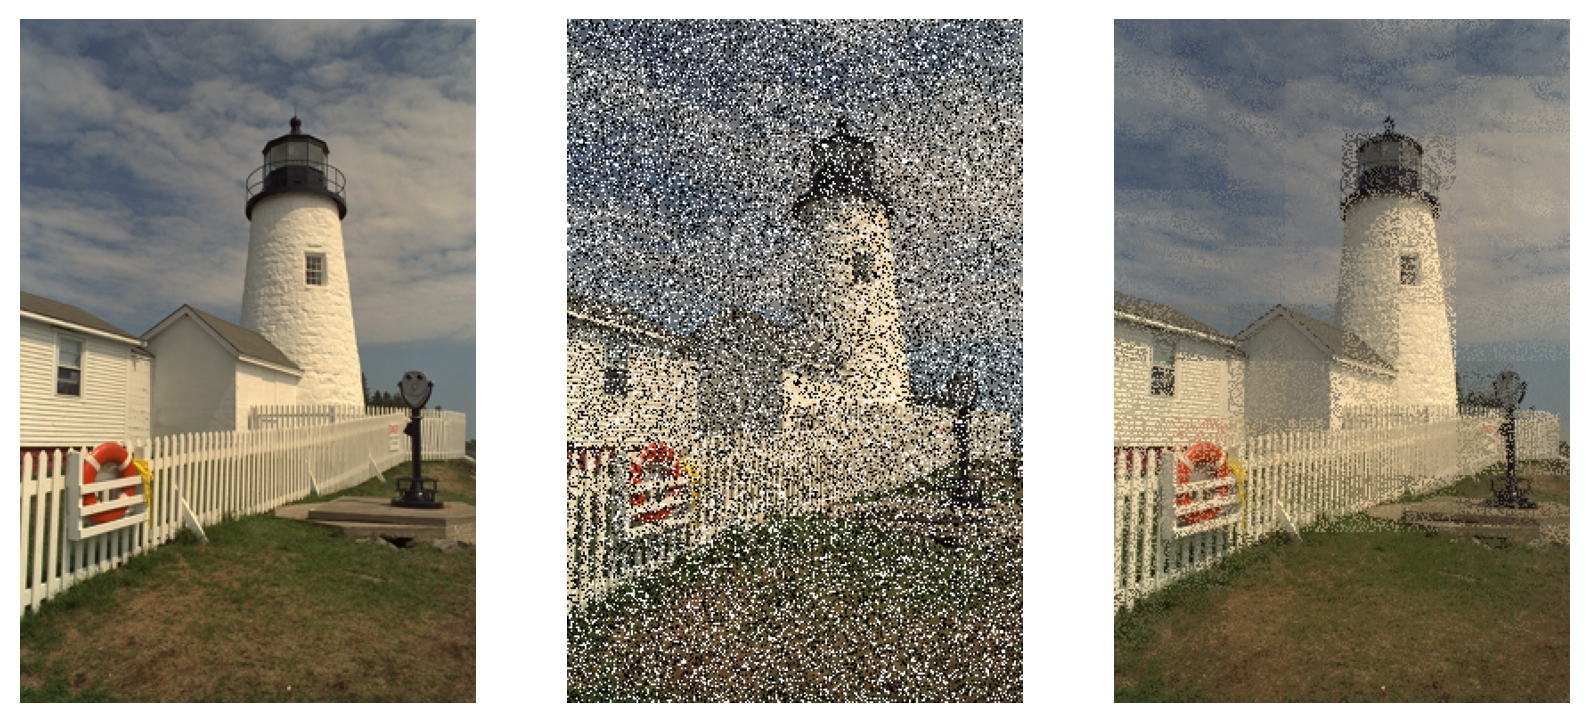

In [5]:
l2_coef = 2
tolerance = 0.01
spacing = 16 # 1 <= spacing <= 9
width = 4 # 1 <= width <= 2 * spacing
patch_size = 32 # >=1
img_recs = []
img_rec = denoising(noisy_img, 
                    spacing=spacing, width=width, 
                    patch_size=patch_size, l2_coeff=l2_coef, 
                    tolerance=tolerance)
fig, axs = plt.subplots(1, 3, figsize=(10, 5), dpi=200)
axs[0].imshow(img)
axs[1].imshow(noisy_img)
axs[2].imshow(img_rec)
axs[0].set_axis_off()
axs[1].set_axis_off()
axs[2].set_axis_off()
plt.show()

**Question:**
Does the denoiser perform well? Do you see any artifacts in the denoised image? What are the potential reasons for these artifacts?

**Answer:**
- The denoiser performed pretty well. 
- I can see the denoised image is splited into chunks of squares.
- The reason for this is because the RBF function fits pixels within the same 
  square with same coloured pixels, so for noised pixels within different 
  squares, they are filled with different color.

## Effect of width

Given a certain `spacing=16`, we run denoising with various widths, raning from 1 to `spacing/2`.
Then the mean squared error is computed between denoised and clean image. The error is visualized as a function of the width size. 
Note that running the experiments could take a few seconds.

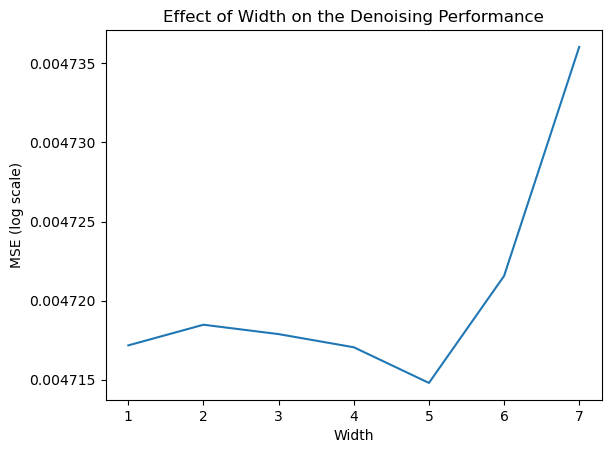

In [6]:
l2_coef = 2.5
tolerance = 0.01

spacing = 16
patch_size = 32
mses = []
widths = np.arange(1, spacing//2).astype(np.int32)
for width in widths:
    img_rec = denoising(noisy_img, 
                        spacing=spacing, width=width, 
                        patch_size=patch_size, l2_coeff=l2_coef, 
                        tolerance=tolerance)
    mse = ((img_rec - img)**2).mean()
    mses.append(mse)
print(mses)
plt.plot(widths, np.log(1+np.array(mses)))
plt.xlabel('Width')
plt.ylabel('MSE (log scale)')
plt.title('Effect of Width on the Denoising Performance')
plt.show()

**Question:**
How does the error change when increasing the width? Justify your answer.

**Answer:**
The error gradually decreases in the range width in [1, 5], increases 
afterwards. The potential reason for such phenomenon is because when the width
is set to a large value, irrelevant data that are far away from the pixel to 
be denoised affects the result of prediction.

## Effect of spacing
Given a fixed `width=3`, we run denoising with various spacings, ranging from `width` to `width*4+1`. Here the goal is to explore the effect of the spacing between basis functions. As before, the mean squared error is computed and visualized.
Note that running the experiments could take a few seconds.

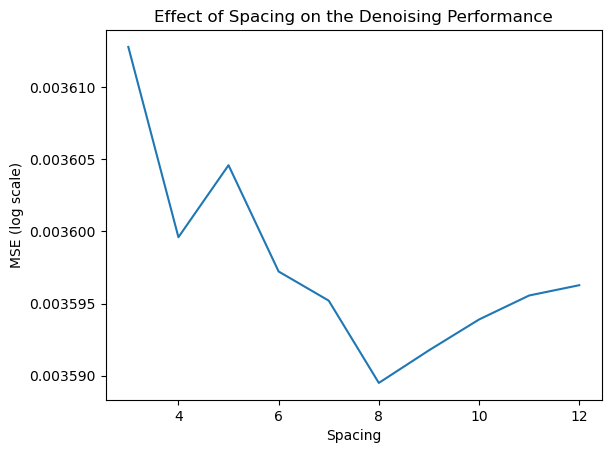

In [8]:
l2_coef = 2.0
tolerance = 0.01

width = 3
patch_size = 16
mses = []
spacings = np.arange(width, width*4+1).astype(np.int32)
for spacing in spacings:
    img_rec = denoising(noisy_img, 
                        spacing=spacing, width=width, 
                        patch_size=patch_size, l2_coeff=l2_coef, 
                        tolerance=tolerance)
    mse = ((img_rec - img)**2).mean()
    mses.append(mse)
plt.plot(spacings, np.log(1+np.array(mses)))
plt.xlabel('Spacing')
plt.ylabel('MSE (log scale)')
plt.title('Effect of Spacing on the Denoising Performance')
plt.show()

**Question:**
Discuss how the error changes when increasing the spacing. Justifications are required.

**Answer:**
The error reaches the optimal when `spacing=7`, then increases as the spacing
diverged from 7. The reason for this pattern is because when spacing is small,
RBF basis are too close to each other so the model is overfitted to noise. 
Whereas when spacing is large, because we set hyperparameter `width=3`, so
there are some pixels lies between to RBF functions that cannot be denoised.